In [1]:
import os 
import pandas as pd 
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
from datetime import timedelta
import re
import paramiko
import numpy as np
import shutil
import plotly.graph_objects as go
from plotly.offline import download_plotlyjs, init_notebook_mode,  iplot


pd.options.plotting.backend = "plotly"

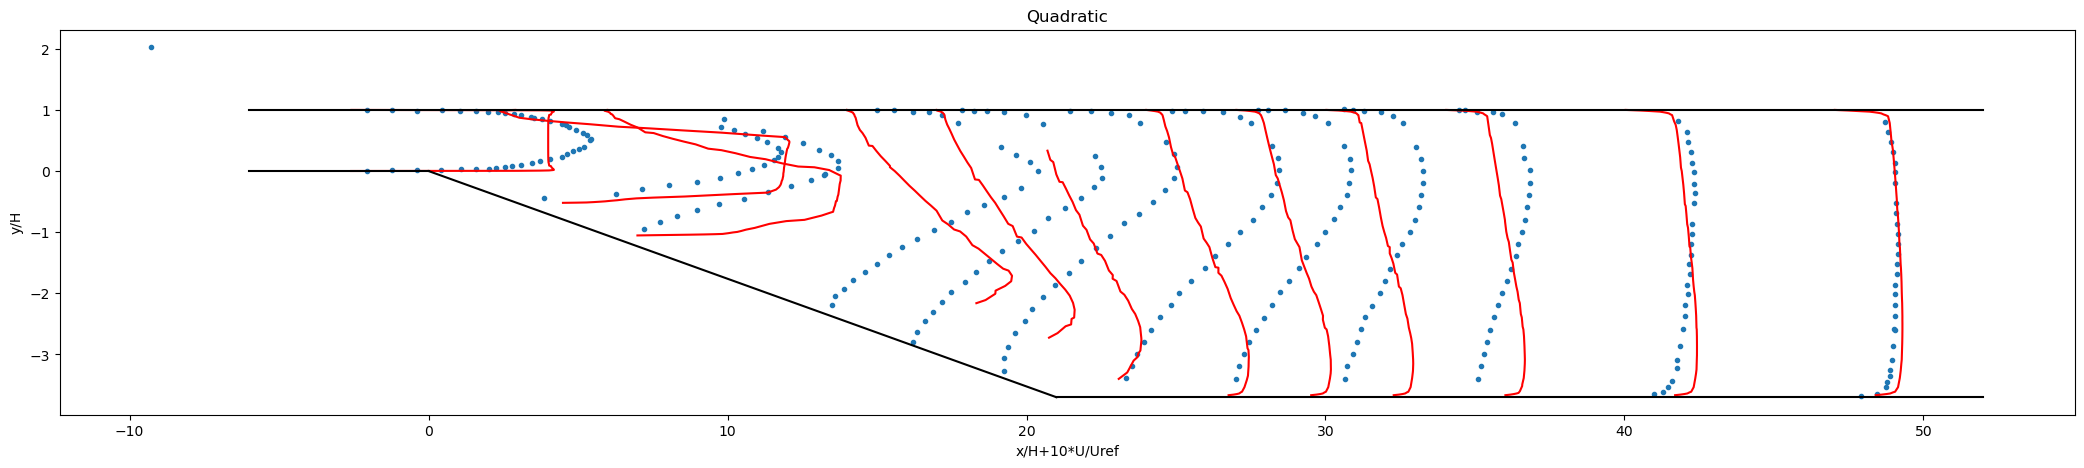

In [58]:
global Diffuser_h
Diffuser_h =0.015
global U_ref
U_ref = 18.32


experiment_dif = pd.read_csv("/home/juleslecoustre/Documents/Diffuser/CASE1/diffuser_inlet.csv")

Profiles_Path = Path("/home/juleslecoustre/Documents/Acqua/Diffuser/PeriodicBC3_inlet2/profiles")
measures = ["-0.06","0.03","0.06","0.14","0.17","0.20","0.24","0.27","0.30","0.34","0.40","0.47"]
Iter = "20000"

fig,ax = plt.subplots(figsize=(26,5))
for mes in measures:
  df = pd.read_csv(Profiles_Path.joinpath("{0}x_{1}.csv".format(mes,Iter)))
  col2  = []
  for col in df.columns:
      col2.append(str(col).strip(' '))
  df.columns = col2
  df["x/H+10U/Uref"] = df["x"]/Diffuser_h + 10*df["U_avg"]/U_ref
  df["y/H"] = df["y"]/Diffuser_h
  ax.plot(df["x/H+10U/Uref"],df["y/H"],c="r")
ax.scatter(experiment_dif["x"],experiment_dif["y1"]/Diffuser_h,marker='.')
ax.plot([-6,0],[0,0],c="black")
ax.plot([0,21],[0,-3.7],c="black")
ax.plot([21,52],[-3.7,-3.7],c="black")
ax.plot([-6,52],[1,1],c="black")
ax.set_xlabel("x/H+10*U/Uref")
ax.set_ylabel("y/H")
ax.set_title("Quadratic")
plt.show()

/home/juleslecoustre/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3505: RankWarning:

Polyfit may be poorly conditioned



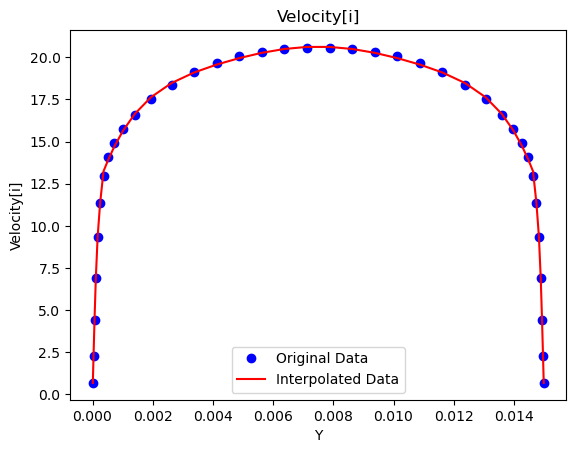

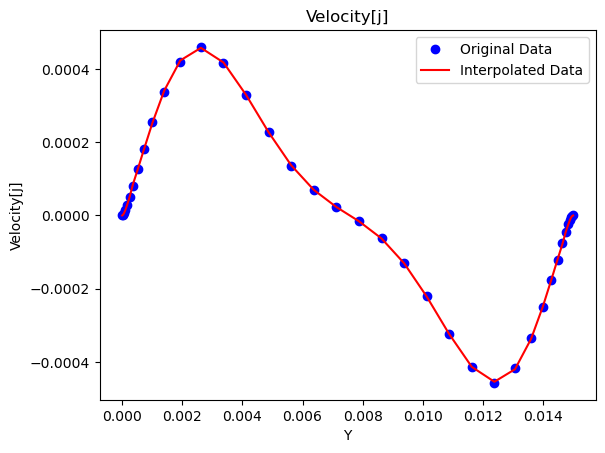

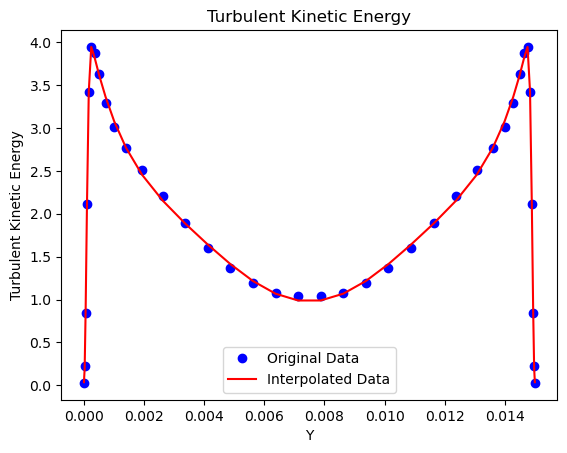

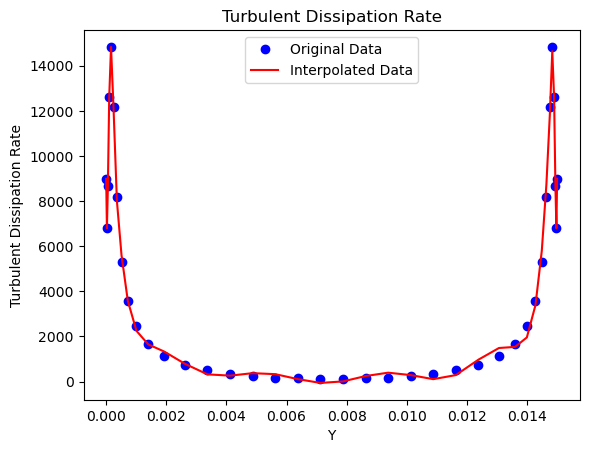

In [18]:
# Input data as a pandas DataFrame
data = pd.read_csv("/home/juleslecoustre/Documents/Diffuser/CASE1/Inlet_fully_developed.csv")

# Variable names
variable_names = ['Velocity[i]', 'Velocity[j]', 'Turbulent Kinetic Energy', 'Turbulent Dissipation Rate']

# Extract Y values
y = data['Y'].values
ymax = np.max(y)
ymin = np.min(y)

# Interpolate each column
interpolated_data = data.copy(deep=True)#pd.DataFrame({"Y": np.linspace(ymin, ymax)})

# Export interpolation functions to a C file
code = """// interpolation_functions.c
#include <stdio.h>
#include <math.h>

"""

for column in variable_names:
    x = data[column].values
    code += f"// {column}\n"
    code += f"double {column.replace(' ','_')}(double y) {{\n"
    code += f"\t// Analytical expression for {column}\n"
    code += f"\tdouble result; "
    if column == 'Turbulent Dissipation Rate':
        # Separate interpolation for turbulent dissipation rate
        
        # Split the data into five parts: 1st to 2nd point, 2nd to 6th, 6th to -6th, -6th to last but one, and last but one to last
        pt_2 = 2
        pt_3 = 6
        pt_4 = -4
        pt_5 = -2
        
        x1 = x[:pt_2]
        x2 = x[pt_2:pt_3]
        x3 = x[pt_3:pt_4]
        x4 = x[pt_4:pt_5]
        x5 = x[pt_5:]
        
        # Interpolate each part separately
        poly_coeffs1 = np.polyfit(y[:pt_2], x1, deg=1)
        poly_coeffs2 = np.polyfit(y[pt_2:pt_3], x2, deg=3)
        poly_coeffs3 = np.polyfit(y[pt_3:pt_4], x3, deg=10)
        poly_coeffs4 = np.polyfit(y[pt_4:pt_5], x4, deg=3)
        poly_coeffs5 = np.polyfit(y[pt_5:], x5, deg=1)
        poly_coeffs_table = [poly_coeffs1,poly_coeffs2,poly_coeffs3,poly_coeffs4,poly_coeffs5]
        # Generate interpolated values for each part
        interpolated_x1 = np.polyval(poly_coeffs1, interpolated_data["Y"])
        interpolated_x2 = np.polyval(poly_coeffs2, interpolated_data["Y"])
        interpolated_x3 = np.polyval(poly_coeffs3, interpolated_data["Y"])
        interpolated_x4 = np.polyval(poly_coeffs4, interpolated_data["Y"])
        interpolated_x5 = np.polyval(poly_coeffs5, interpolated_data["Y"])
        
        # Concatenate the interpolated values
        interpolated_x = np.concatenate([interpolated_x1[:pt_2], interpolated_x2[pt_2:pt_3], 
                                         interpolated_x3[pt_3:pt_4], interpolated_x4[pt_4:pt_5], interpolated_x5[pt_5:]])
        
        # Separate interpolation segments
        segments = [interpolated_x1[:pt_2], interpolated_x2[pt_2:pt_3], interpolated_x3[pt_3:pt_4],
                    interpolated_x4[pt_4:pt_5], interpolated_x5[pt_5:]]
        segment_indices = [f"(y <= {y[pt_2]:.15e})", 
                           f"({y[pt_2]:.15e} < y && y <= {y[pt_3]:.15e})", 
                           f"({y[pt_3]:.15e} < y && y <= {y[pt_4]:.15e})", 
                           f"({y[pt_4]:.15e} < y && y <= {y[pt_5]:.15e})", 
                           f"({y[pt_5]:.15e} < y)"]

        for i, segment in enumerate(segments):
            code += f"\n\tif {segment_indices[i]} {{\n\t  epsilon = {poly_coeffs_table[i][-1]}"
            for j in range(0, len(poly_coeffs_table[i])-1):
                if j%2 == 0:
                   code += '\n\t\t\t\t\t '
                if poly_coeffs_table[i][j] > 0:
                  code += f" + {poly_coeffs_table[i][j]:.15e} * y" +'*y'*(len(poly_coeffs_table[i])-2-j)
                else:
                  code += f" - {abs(poly_coeffs_table[i][j]):.15e} * y" +'*y'*(len(poly_coeffs_table[i])-2-j)
            if i != len(segments) - 1:
                code += "; \n\t}"
    else:
        # Separate interpolation for turbulent quantities
        
        # Split the data into three parts: first 4 points, last 4 points, and the rest
        pt_1 = 6
        pt_2 = -6
        x1 = x[:pt_1]
        x2 = x[pt_2:]
        x3 = x[pt_1:pt_2]
        
        # Interpolate each part separately
        poly_coeffs1 = np.polyfit(y[:pt_1], x1, deg=4)
        poly_coeffs2 = np.polyfit(y[pt_2:], x2, deg=4)
        poly_coeffs3 = np.polyfit(y[pt_1:pt_2], x3, deg=7)
        
        poly_coeffs_table = [poly_coeffs1,poly_coeffs3,poly_coeffs2]
        # Generate interpolated values for each part
        interpolated_x1 = np.polyval(poly_coeffs1, interpolated_data["Y"])
        interpolated_x2 = np.polyval(poly_coeffs2, interpolated_data["Y"])
        interpolated_x3 = np.polyval(poly_coeffs3, interpolated_data["Y"])
        
        # Concatenate the interpolated values
        interpolated_x = np.concatenate([interpolated_x1[:pt_1], interpolated_x3[pt_1:pt_2], interpolated_x2[pt_2:]])
        # Separate interpolation segments
        segments = [interpolated_x1[:pt_1], interpolated_x3[pt_1:pt_2], interpolated_x2[pt_2:]]
        segment_indices = [f"(y <= {y[pt_1]:.15e})", 
                           f"({y[pt_1]:.15e} < y && y <= {y[pt_2]:.15e})", 
                           f"({y[pt_2]:.15e} < y)"]

        for i, segment in enumerate(segments):
            code += f"\n\tif {segment_indices[i]} {{\n\t  result = {poly_coeffs_table[i][-1]}"
            for j in range(0, len(poly_coeffs_table[i])-1):
                if j%2 == 0:
                   code += '\n\t\t\t\t\t'
                if poly_coeffs_table[i][j] > 0:
                  code += f" + {poly_coeffs_table[i][j]:.15e} * y" +'*y'*(len(poly_coeffs_table[i])-2-j)
                else:
                  code += f" - {abs(poly_coeffs_table[i][j]):.15e} * y" +'*y'*(len(poly_coeffs_table[i])-2-j)
            if i != len(segments) - 1:
                code += "; \n\t}"
    code += f";\n"
    code += "\t}\n\treturn result;\n}\n\n"
    interpolated_data[column] = interpolated_x

# Plot original data vs interpolated for each variable
for column in variable_names:
    x = data[column].values
    interpolated_x = interpolated_data[column].values
    variable_name = column

    plt.figure()
    plt.plot(y, x, 'bo', label='Original Data')
    plt.plot(interpolated_data["Y"], interpolated_x, 'r-', label='Interpolated Data')
    plt.xlabel('Y')
    plt.ylabel(variable_name)
    plt.title(variable_name)
    plt.legend()
    plt.show()


# Write the code to a file
with open("interpolation_functions2.c", "w") as file:
    file.write(code)